<a href="https://colab.research.google.com/github/danmenloz/LeafWilting/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 21
## Project 1.2: Leafwilting Detection in Soybean
This script is used to train the model using training and validation data. The implementation of model is based on the VGG16 model using transfer learning.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
 
import keras
from keras.models import Model, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Augmentation
Here we create an instance of the *ImageDataGenerator* class:
https://keras.io/api/preprocessing/image/

It allow us to generate images during training with different augmentation schemes.


In [4]:
# Training and validation data generator

# Uncomment scheme to apply it
datagen = ImageDataGenerator(
  rescale=1./255,
	rotation_range=30,
	zoom_range=0.15, # [1-zoom_range,1+zoom_range]
	# width_shift_range=0.2,
	# height_shift_range=0.2,
	# shear_range=0.15,
  brightness_range=[0.5,1.5],
	horizontal_flip=True,
	fill_mode="reflect") #  nearest

# Create iterators
base_path = "drive/My Drive/ECE_542-Project_1/"
datasets_paths = [ os.path.join(base_path,'data/test/'),
                   os.path.join(base_path,'data/train/'),
                   os.path.join(base_path,'data/validation/'),
                   os.path.join(base_path,'data/prediction/') ]

img_size = (224,224) # standard image size for the VGG16 model
b_size = 32 

# Iterator for the training dataset
train_it = datagen.flow_from_directory(datasets_paths[1], batch_size=b_size, target_size=img_size)
# Iterator for the validation dataset
val_it = datagen.flow_from_directory(datasets_paths[2],  batch_size=b_size, target_size=img_size)

Found 820 images belonging to 5 classes.
Found 355 images belonging to 5 classes.


Inspect the data-augmented dataset

(32, 224, 224, 3)
(32, 5)


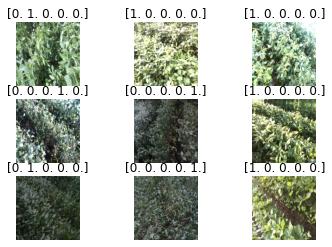

In [5]:
# Plot images from dataset
gen_imgs, gen_lbls = next(train_it)
print(gen_imgs.shape)
print(gen_lbls.shape)

# Plot 9 images
NUM_IMG = 9 
for i, (image, label) in enumerate(zip(gen_imgs,gen_lbls)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(str(label))
  plt.axis("off")
  if i >= NUM_IMG-1:
    break

### Balancing the dataset
Instead of creating multiple images to balance the dataset, apply different weights to the classes. This weight will be used in the loss function.

In [6]:
# Class weights 
# See Dataset.ipybn for details of calculation
c_weights = {0: 0.5015290519877675, 
             1: 0.7592592592592593, 
             2: 2.1298701298701297, 
             3: 2.1298701298701297, 
             4: 1.3333333333333333}
print(c_weights)

{0: 0.5015290519877675, 1: 0.7592592592592593, 2: 2.1298701298701297, 3: 2.1298701298701297, 4: 1.3333333333333333}


### Model
Here we have used transfer learning from the VGG16 model following these steps: https://keras.io/guides/transfer_learning/

In [7]:
# Transfer learning

# loading the vgg16 model
from keras.applications.vgg16 import VGG16

# load model and specify a new input shape for images
vgg = VGG16(input_shape=(img_size[0], img_size[1], 3), include_top=True) # True=include FC layers

# Freeze model layers
for layer in (vgg.layers)[:19]: # Freeze all convolutional layers
    layer.trainable = False

# Replace vgg output layer
x = vgg.layers[-2].output
prediction = Dense(5, activation="softmax")(x) # 5 classes

# Creating instance
model = Model(inputs = vgg.input, outputs = prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])

# summarize the model
model.summary()

553467904/553467096 [==============================] - 19s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________

### Training
Here we train the model using *Early Stopping* and *Model Check Point*. The first one prevents overfitting and the later saves the best model during training.

In [8]:
# Train the model

# Early stopping and model checkpoint
save_path = os.path.join(base_path,'vgg16_model.h5') # path to save the model
# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(save_path, monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(
    train_it,
    steps_per_epoch = train_it.samples//train_it.batch_size, # steps limited per the number of images in the dataset
    validation_data=val_it,
    validation_steps = val_it.samples//val_it.batch_size, # steps limited per the number of images in the dataset
    epochs = 100, # max number of epochs
    class_weight=c_weights,
    callbacks=[es, mc], 
    verbose=1)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 7.3959 - categorical_accuracy: 0.2678 
Epoch 00001: val_categorical_accuracy improved from -inf to 0.45739, saving model to drive/My Drive/ECE_542-Project_1/vgg16_model.h5
25/25 [==============================] - 764s 31s/step - loss: 7.3959 - categorical_accuracy: 0.2678 - val_loss: 1.2512 - val_categorical_accuracy: 0.4574
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 1.3549 - categorical_accuracy: 0.4226
Epoch 00002: val_categorical_accuracy improved from 0.45739 to 0.62784, saving model to drive/My Drive/ECE_542-Project_1/vgg16_model.h5
25/25 [==============================] - 38s 2s/step - loss: 1.3549 - categorical_accuracy: 0.4226 - val_loss: 0.9868 - val_categorical_accuracy: 0.6278
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 1.1247 - categorical_accuracy: 0.5444
Epoch 00003: val_categorical_accuracy did not improve from 0.62784
25/25 [===========================

### Trainining results
Here we show the loss and accuracy plots.

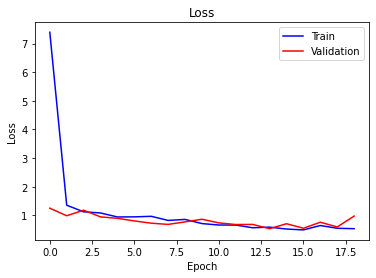

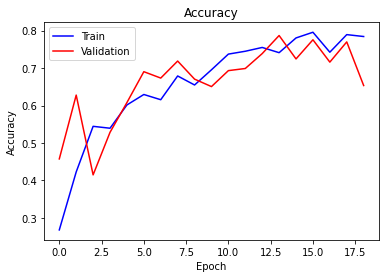

In [9]:
def plot_history(history):
      # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
 
# Plotting results of training
plot_history(history)

### Fine Tunning
Here we attempt to improve the performance by unfreezing all the layers of the model and training them for a few epochs with a very low learning rate.

Epoch 1/5
25/25 [==============================] - ETA: 0s - loss: 0.4566 - categorical_accuracy: 0.8211
Epoch 00001: val_categorical_accuracy did not improve from 0.78693
25/25 [==============================] - 29s 1s/step - loss: 0.4566 - categorical_accuracy: 0.8211 - val_loss: 0.5785 - val_categorical_accuracy: 0.7670
Epoch 2/5
25/25 [==============================] - ETA: 0s - loss: 0.4947 - categorical_accuracy: 0.8109
Epoch 00002: val_categorical_accuracy improved from 0.78693 to 0.79261, saving model to drive/My Drive/ECE_542-Project_1/vgg16_model.h5
25/25 [==============================] - 34s 1s/step - loss: 0.4947 - categorical_accuracy: 0.8109 - val_loss: 0.5521 - val_categorical_accuracy: 0.7926
Epoch 3/5
25/25 [==============================] - ETA: 0s - loss: 0.4501 - categorical_accuracy: 0.8096
Epoch 00003: val_categorical_accuracy did not improve from 0.79261
25/25 [==============================] - 31s 1s/step - loss: 0.4501 - categorical_accuracy: 0.8096 - val_loss

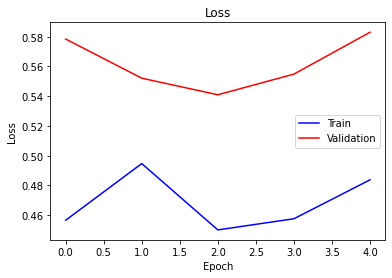

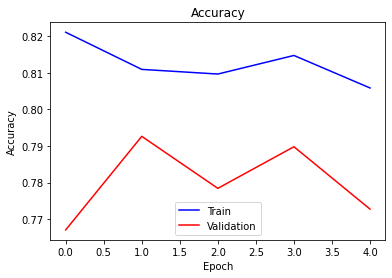

In [10]:
# Fine tunning

# Load best model
model = load_model(save_path)

# Unfreeze model
vgg.trainable = True
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=0.00001),# Very low learning rate
                    metrics=['categorical_accuracy'])

history1 = model.fit(
    train_it,
    steps_per_epoch = train_it.samples//train_it.batch_size,
    validation_data=val_it,
    validation_steps = val_it.samples//val_it.batch_size,
    epochs = 5,
    class_weight=c_weights, 
    callbacks=[mc],
    verbose=1)

# Plotting results
plot_history(history1)